<a href="https://colab.research.google.com/github/tjohanne42/time_series_project_simplon/blob/main/dev_files/time_series_collab_notebook_arthur.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# !pip3 install --upgrade statsmodels

In [1]:
!git clone https://github.com/tjohanne42/time_series_project_simplon.git
%cd time_series_project_simplon/

Cloning into 'time_series_project_simplon'...
remote: Enumerating objects: 113, done.
remote: Counting objects: 100% (113/113), done.
remote: Compressing objects: 100% (69/69), done.
remote: Total 113 (delta 43), reused 68 (delta 20), pack-reused 0
Receiving objects: 100% (113/113), 10.76 MiB | 18.76 MiB/s, done.
Resolving deltas: 100% (43/43), done.
/content/time_series_project_simplon


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm.notebook import tqdm
import numpy as np
from scipy.interpolate import make_interp_spline, BSpline
from datetime import datetime
from pathlib import Path
import sys
tqdm.pandas()

from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
import keras
from keras.models import Sequential
from keras.layers import Input, Dense, Dropout, LSTM, Conv1D, GlobalMaxPooling1D, SimpleRNN
from tqdm.keras import TqdmCallback
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.utils.vis_utils import plot_model
from tensorflow.keras.optimizers import RMSprop, Adam           # Adam better

from utils.functions import generate_df_by_time_section

pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', 20)

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
import tensorflow as tf
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

# import dataset

weekly nuclear production of energy

In [4]:
!dir

data  preprocess_data.ipynb  README.md	subject_fr.PNG	utils


In [5]:
df_week = generate_df_by_time_section(time_section="week", verbose=True)
df_week

set the timestamp seconds, minutes and hours to 0 ...


  0%|          | 0/796411 [00:00<?, ?it/s]

get the mean of every hours for every days ...
add a column week
add a column year ...


  0%|          | 0/2772 [00:00<?, ?it/s]

get the mean of every day for every week ...
retrive the timestamp of the first day of each week ...
multiply all values by 12 * 24 * 7 to get the actual values by week ...
done


,timestamp,year,week,coal,nuclear,wind,hydro,solar
0,2012-01-01,4054176,104832,1.713828e+07,1.420676e+07,5.322716e+06,1.585388e+06,0.000000e+00
1,2012-01-02,4056192,2016,2.914531e+07,1.501550e+07,4.839885e+06,1.635379e+06,0.000000e+00
2,2012-01-09,4056192,4032,3.676549e+07,1.460764e+07,2.751943e+06,1.566100e+06,0.000000e+00
3,2012-01-16,4056192,6048,3.644392e+07,1.524003e+07,4.198388e+06,1.267458e+06,0.000000e+00
4,2012-01-23,4056192,8064,3.853616e+07,1.670473e+07,2.227393e+06,1.345945e+06,0.000000e+00
...,...,...,...,...,...,...,...,...
393,2019-07-01,4070304,54432,0.000000e+00,9.631355e+06,7.683682e+06,3.867220e+05,4.858098e+06
394,2019-07-08,4070304,56448,1.557690e+05,9.956678e+06,3.944752e+06,5.637490e+05,3.799916e+06
395,2019-07-15,4070304,58464,9.756300e+04,1.119766e+07,6.731582e+06,5.027580e+05,3.807794e+06
396,2019-07-22,4070304,60480,4.317600e+04,1.071334e+07,9.077357e+06,7.786470e+05,3.918022e+06


In [6]:
df_nuclear_week = df_week[["timestamp", "nuclear"]]
df_nuclear_week

,timestamp,nuclear
0,2012-01-01,1.420676e+07
1,2012-01-02,1.501550e+07
2,2012-01-09,1.460764e+07
3,2012-01-16,1.524003e+07
4,2012-01-23,1.670473e+07
...,...,...
393,2019-07-01,9.631355e+06
394,2019-07-08,9.956678e+06
395,2019-07-15,1.119766e+07
396,2019-07-22,1.071334e+07


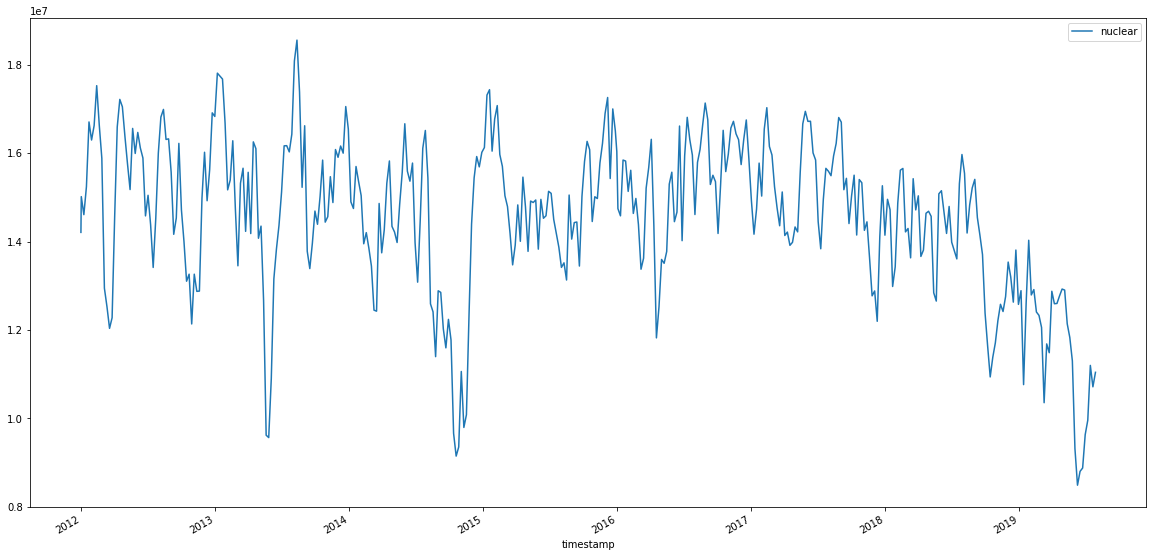

In [7]:
# df_nuclear_week.plot(figsize=(20,10))
df_nuclear_week.set_index(keys="timestamp").plot(figsize=(20,10))

# LSTM

- LSTM activation -> Sigmoid, tanh
- activation = "tanh", recurrent
- learning rate = 0.001, adam optimizer
- train, val, test set
- LSTM, dense, dropout layers
- Relu, leaky Relu, P Relu activation functions
- N input timestamps, M output timestamps

## train, validation, test sets

train (split_1) validation (split_2) test

In [ ]:
index_split_1 = round(len(df_nuclear_week) * 0.7)
index_split_2 = round(len(df_nuclear_week) * 0.8)

train = df_nuclear_week.iloc[:index_split_1, 1].values.reshape(-1, 1)
val = df_nuclear_week.iloc[index_split_1:index_split_2, 1].values.reshape(-1, 1)
test = df_nuclear_week.iloc[index_split_2:, 1].values.reshape(-1, 1)

In [ ]:
print(train.shape)
print(val.shape)
print(test.shape)

## MinMax scaling

In [ ]:
scaler = MinMaxScaler()

scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_val = scaler.transform(val)
scaled_test = scaler.transform(test)

print(scaled_train.min(), scaled_train.max())

## Time series Generator

In [ ]:
input_length = 24
features_length = 1
batch_size = 5
generator = TimeseriesGenerator(scaled_train, scaled_train, length=input_length, batch_size=batch_size)

In [ ]:
x, y = generator[0]
# print(x)
# print(y)

In [ ]:
len(generator)

In [ ]:
print(x.shape)
print(y.shape)

x (input) shape = (batch size, input length, feature length)<br>
y (expected output) shape = (batch size, feature length)

## create a model

In [ ]:
inputs = Input(shape=(input_length, features_length))

main = Dense(n_lag, activation="relu")(inputs)
main = LSTM(256, activation="relu", return_sequences=True)(main)
main = LSTM(128, activation="relu", return_sequences=True)(main)
main = LSTM(64, activation="relu")(main)
# main = Dense(64, activation="relu")(main)
main = Dense(n_lag, activation=None, name='output')(main)

model = Model(inputs, main)

model.summary()
plot_model(model, to_file="blbl.png", show_shapes=True)

model.compile(
  # optimizer = Adam(learning_rate=0.001),
  optimizer = RMSprop(learning_rate=0.001),
  loss = "mse",
)